In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# Data Preprocessing

In [2]:
df = pd.read_csv('../input/paddy-disease-classification/train.csv')
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [3]:
print(df['label'].unique(), '\n')
print(df['variety'].unique(), '\n')
print(df['age'].unique())

['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro'] 

['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR'] 

[45 50 55 60 65 68 70 72 47 77 67 73 75 80 62 66 57 82]


<AxesSubplot:xlabel='label', ylabel='count'>

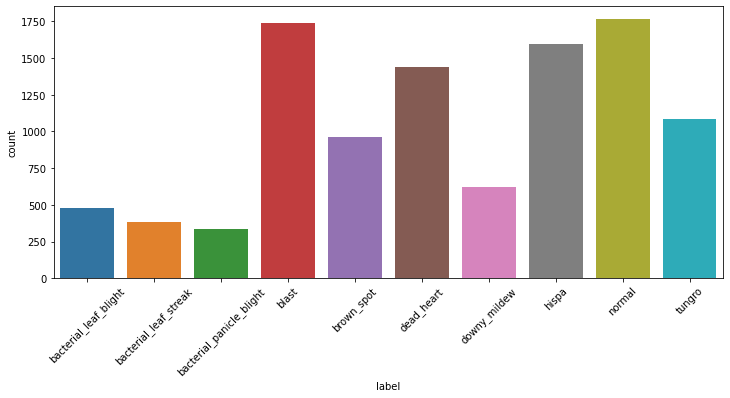

In [4]:
f, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation = 45)
sns.countplot(x='label',data=df)
#plt.xticks(rotation = 90)

In [5]:
labels = os.listdir('../input/paddy-disease-classification/train_images')
labels

['tungro',
 'hispa',
 'downy_mildew',
 'bacterial_leaf_streak',
 'bacterial_leaf_blight',
 'brown_spot',
 'blast',
 'normal',
 'dead_heart',
 'bacterial_panicle_blight']

In [6]:
train_dir = '../input/paddy-disease-classification/train_images'
BATCH_SIZE = 64
IMG_SIZE = (500, 500)
labels = os.listdir('../input/paddy-disease-classification/train_images')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            labels='inferred',
                                                            class_names = labels,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed=47,
                                                            label_mode='categorical',
                                                            validation_split=0.1,
                                                            subset='training')
val_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            labels='inferred',
                                                            class_names = labels,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed=47,
                                                            label_mode='categorical',
                                                            validation_split=0.1,
                                                            subset='validation')

Found 10407 files belonging to 10 classes.
Using 9367 files for training.


2022-06-12 10:09:54.695169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 10:09:54.864078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 10:09:54.865060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 10:09:54.868106: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


## Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
print("finished")

finished


# Deep Learning Model

 ## Rescale pixel values
 for use as your base model. This model expects pixel values in [-1, 1] but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [8]:
#preprocessing layer so that the image can be trained using mobilenet 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Load transfer learning model (mobilenetv2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(500, 500, 3),
                                               include_top=False,
                                               weights='imagenet')
#freeze transfer learning model, because when we try unfreeze the top layer it results lower accuracy
base_model.trainable = False
print("finished")

9420800/9406464 [==============================] - 0s 0us/step
finished


In [9]:
inputs = tf.keras.Input(shape=(500, 500, 3))
x = preprocess_input(inputs)
#x = data_augmentation(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.10)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 500, 500, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 500, 500, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096  

In [10]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(train_dataset,
                    epochs=16,
                    validation_data=val_dataset,
                    callbacks=[learning_rate_reduction])

Epoch 1/16


2022-06-12 10:10:03.949720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-12 10:10:09.253189: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - 92s 535ms/step - loss: 1.1817 - accuracy: 0.6200 - val_loss: 1.1295 - val_accuracy: 0.6154
Epoch 2/16
147/147 [==============================] - 66s 434ms/step - loss: 0.6202 - accuracy: 0.8071 - val_loss: 0.8331 - val_accuracy: 0.7144
Epoch 3/16
147/147 [==============================] - 66s 433ms/step - loss: 0.4350 - accuracy: 0.8640 - val_loss: 0.5717 - val_accuracy: 0.8154
Epoch 4/16
147/147 [==============================] - 64s 424ms/step - loss: 0.3298 - accuracy: 0.8960 - val_loss: 0.4854 - val_accuracy: 0.8471
Epoch 5/16
147/147 [==============================] - 64s 423ms/step - loss: 0.2569 - accuracy: 0.9199 - val_loss: 0.4090 - val_accuracy: 0.8721
Epoch 6/16
147/147 [==============================] - 65s 423ms/step - loss: 0.2303 - accuracy: 0.9248 - val_loss: 0.4277 - val_accuracy: 0.8644
Epoch 7/16
147/147 [==============================] - 65s 426ms/step - loss: 0.1875 - accuracy: 0.9427 - val_loss: 0.4410 - val_accuracy: 0.8

# Metrics Evaluation

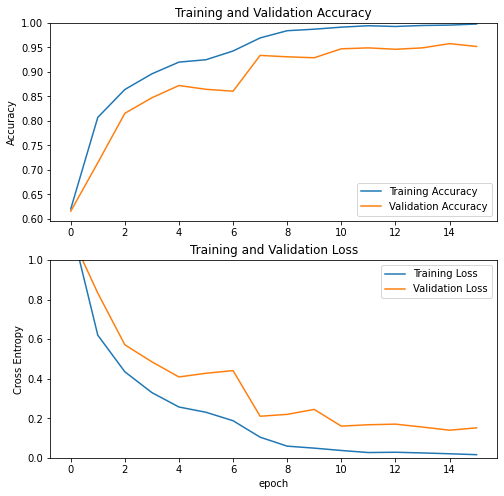

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [6 4 5 4 6 5 7 0 1 9 7 0 8 7 3 8 9 1 6 8 7 8 5 7 7 0 1 8 7 0 1 1 8 7 1 5 6
 5 1 1 0 7 8 2 2 6 8 7 6 8 8 8 8 1 0 8 0 8 8 8 1 0 6 6]
Labels:
 [6 4 5 4 6 8 7 0 1 9 7 0 8 7 3 8 9 1 6 8 7 8 5 7 7 0 1 8 7 0 1 1 8 7 1 5 6
 5 1 1 0 7 8 2 2 6 8 7 6 8 8 8 8 1 0 9 0 8 8 8 1 0 6 6]


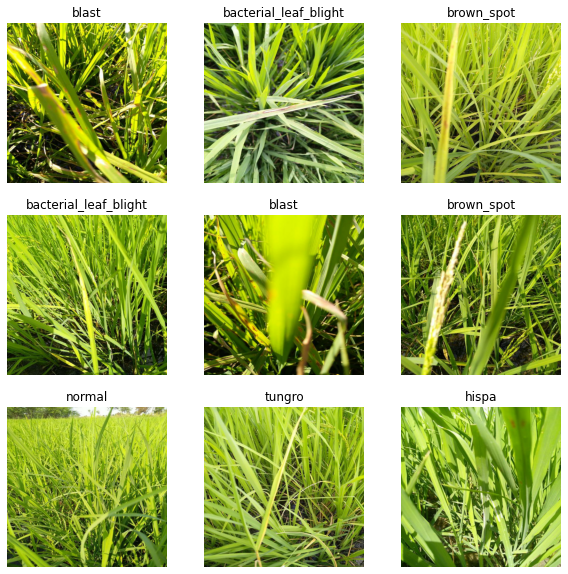

In [14]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=-1)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.softmax(predictions)
#predictions = tf.where(predictions.ar)

print('Predictions:\n', predictions)
print('Labels:\n', np.argmax(label_batch, axis=-1))

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(labels[predictions[i]])
    plt.axis("off")


# Saving Model

In [15]:
# save to .h5 format 
model.save('./model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
# save to .tflite format
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2022-06-12 10:30:32.126535: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-06-12 10:30:48.823302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 10:30:48.823679: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-06-12 10:30:48.823880: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-06-12 10:30:48.824600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.